<a href="https://colab.research.google.com/github/epsilon-deltta/amazon-review/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Flatten  

from keras.layers import Conv2D,MaxPooling1D,MaxPooling2D ,Conv1D

from keras.layers import Dropout
from keras.layers import Embedding , LSTM

from keras.callbacks import ModelCheckpoint,EarlyStopping

In [9]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

#### Do once (load , nlp preprocess , build Embedding Matrix ) 

In [61]:
# in colab
# preprocess
# embedding
# xtr,ytr,xte,yte, embedding_matrix,vocab_size,vector_size = load_data(path)
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
def load_pdata(validation=True) :
    if not os.path.exists('data'):
        os.system('git clone https://github.com/epsilon-deltta/dataset data')
        path = './data/amazon-review/'
    else :
        if os.path.exists('data/amazon-review'):
            path = './data/amazon-review/'
        else:
            path = './data/'

    def load_data(path='./data/'):
        testdir  = path + 'test/'
        traindir = path + 'train/'

        df = [ pd.DataFrame(columns = ['n','review','target']) for _ in range(2)]

        for i,path in enumerate([traindir,testdir]):
            path = path
            label = 'positive'

            poslist = [ os.path.join(path,label,name) for name in os.listdir(path+label) ]

            label = 'negative' 
            neglist = [ os.path.join(path,label,name) for name in os.listdir(path+label) ]

            sep = os.path.sep

            for fpath in poslist :
                num = fpath.split(sep)[-1]
                with open(fpath,'r') as f :
                    content = f.read()

                item = dict(zip(df[i].columns,[num,content,1] ) )
                df[i] = df[i].append(item,ignore_index=True)

            for fpath in neglist :
                num = fpath.split(sep)[-1]
                with open(fpath,'r') as f :
                    content = f.read()

                item = dict(zip(df[i].columns,[num,content,0] ) )
                df[i] = df[i].append(item,ignore_index=True)
        return df[0].review,df[0].target,df[1].review,df[1].target

    xtr,ytr,xte,yte = load_data(path)

    from tensorflow.keras.preprocessing.text import text_to_word_sequence,Tokenizer
    from keras.preprocessing import text

    # - Word Index: keep the most frequent 10k words
    vocab_size = 10000
    token = Tokenizer(num_words = vocab_size + 1) # 상위 10000개 단어만 사용

    token.fit_on_texts(xtr)
    max_len = 400
    def preprocess(docs,token,max_len=400):
        docs = token.texts_to_sequences(docs)
        
        from tensorflow.keras.preprocessing.sequence import pad_sequences
        docs = pad_sequences(docs, maxlen=max_len)
        
        return docs

    xtr = preprocess(xtr,token)
    xte = preprocess(xte,token)

    # - Word embedding dimension: 100
    # vocab_size  = token.num_words # 10000+ 1 
    vector_size = 100  #100
    vocab_size = 10001

    def get_emb_mtr():
        wv = pd.read_csv(path+'all.review.vec.txt',sep=' ',skiprows=1,header=None)

        wv.set_index(0,inplace=True)
        del wv[101]


        embedding_matrix = np.zeros((vocab_size, vector_size))

        def get_vector(word):
            if word in wv.index:
                return wv.loc[word]
            else:
                return None

        num = 0
        word_index = [( i,word) for i,word in token.index_word.items()][:10000]
        # not_used = []
        for i,word in word_index: 
            temp = get_vector(word)
            if temp is not None: 

                embedding_matrix[i] = temp # 해당 단어 위치의 행에 벡터의 값을 저장한다.
        #     else :
        #         not_used.append(word)
        #         num+=1
        return embedding_matrix

    embedding_matrix = get_emb_mtr()

    xtr = xtr.astype('float')
    xte = xte.astype('float')
    ytr = ytr.astype('float')
    yte = yte.astype('float')

    if validation :
        from sklearn.model_selection import train_test_split
        xtr, xval, ytr, yval = train_test_split(xtr, yte, test_size=0.3, random_state=10)
        return xtr,ytr,xval,yval,xte,yte, embedding_matrix,vocab_size,vector_size,max_len
    
    else :
        return xtr,ytr,xte,yte, embedding_matrix,vocab_size,vector_size
    
xtr,ytr,xval,yval,xte,yte,embedding_matrix,vocab_size,vector_size,max_len = load_pdata()

#### load data

In [3]:
# in colab
!git clone https://github.com/epsilon-deltta/dataset data
path = './data/amazon-review/'

Cloning into 'data'...
remote: Enumerating objects: 3937, done.
remote: Counting objects: 100% (3937/3937), done.
remote: Compressing objects: 100% (3936/3936), done.
remote: Total 3937 (delta 0), reused 3937 (delta 0), pack-reused 0
Receiving objects: 100% (3937/3937), 23.43 MiB | 18.07 MiB/s, done.


In [10]:
# in local
path     = './data/'

In [11]:
def load_data(path='./data/'):
    testdir  = path + 'test/'
    traindir = path + 'train/'

    df = [ pd.DataFrame(columns = ['n','review','target']) for _ in range(2)]

    for i,path in enumerate([traindir,testdir]):
        path = path
        label = 'positive'

        poslist = [ os.path.join(path,label,name) for name in os.listdir(path+label) ]

        label = 'negative' 
        neglist = [ os.path.join(path,label,name) for name in os.listdir(path+label) ]

        sep = os.path.sep

        for fpath in poslist :
            num = fpath.split(sep)[-1]
            with open(fpath,'r') as f :
                content = f.read()

            item = dict(zip(df[i].columns,[num,content,1] ) )
            df[i] = df[i].append(item,ignore_index=True)

        for fpath in neglist :
            num = fpath.split(sep)[-1]
            with open(fpath,'r') as f :
                content = f.read()

            item = dict(zip(df[i].columns,[num,content,0] ) )
            df[i] = df[i].append(item,ignore_index=True)
    return df[0].review,df[0].target,df[1].review,df[1].target

xtr,ytr,xte,yte = load_data(path)

#### tokenizing 

In [12]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence,Tokenizer
from keras.preprocessing import text

# - Word Index: keep the most frequent 10k words
vocab_size = 10000
token = Tokenizer(num_words = vocab_size + 1) # 상위 10000개 단어만 사용

token.fit_on_texts(xtr)
max_len = 400
def preprocess(docs,token,max_len=400):
    docs = token.texts_to_sequences(docs)
    
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    docs = pad_sequences(docs, maxlen=max_len)
    
    return docs

xtr = preprocess(xtr,token)
xte = preprocess(xte,token)

Let me make Embedding Matrix !! 

In [13]:
# - Word embedding dimension: 100
# vocab_size  = token.num_words # 10000+ 1 
vector_size = 100  #100
vocab_size = 10001

def get_emb_mtr():
    wv = pd.read_csv(path+'all.review.vec.txt',sep=' ',skiprows=1,header=None)

    wv.set_index(0,inplace=True)
    del wv[101]


    embedding_matrix = np.zeros((vocab_size, vector_size))

    def get_vector(word):
        if word in wv.index:
            return wv.loc[word]
        else:
            return None

    num = 0
    word_index = [( i,word) for i,word in token.index_word.items()][:10000]
    # not_used = []
    for i,word in word_index: 
        temp = get_vector(word)
        if temp is not None: 

            embedding_matrix[i] = temp # 해당 단어 위치의 행에 벡터의 값을 저장한다.
    #     else :
    #         not_used.append(word)
    #         num+=1
    return embedding_matrix

embedding_matrix = get_emb_mtr()

xtr = xtr.astype('float')
xte = xte.astype('float')
ytr = ytr.astype('float')
yte = yte.astype('float')

#### Models 

In [15]:
def get_model():
    # cnn w/o pre-emb
    model0 = Sequential()
    e = Embedding(vocab_size, vector_size)
    model0.add(e)
    model0.add(Conv1D(100, 3, padding='valid', activation='relu',strides=1))
    model0.add(Dense(100))
    model0.add(Dense(1,activation='sigmoid'))
    # model1.add(MaxPooling1D(pool_size=4))
    model0.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    # cnn w/ pretrained model
    model1 = Sequential()
    e = Embedding(vocab_size, vector_size, weights=[embedding_matrix], input_length=max_len, trainable=False)
    model1.add(e)
    # model1.add(Flatten())
    # model.add(Dropout(0.5)) 
    model1.add(Conv1D(100, 3, padding='valid', activation='relu',strides=1))
    model1.add(Dense(100))
    model1.add(Dense(1,activation='sigmoid'))
    # model1.add(MaxPooling1D(pool_size=4))
    # model1.add(LSTM(55))
    model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    # lstm model w/ pre-emb
    model2 = Sequential()
    e = Embedding(vocab_size, vector_size, weights=[embedding_matrix], input_length=max_len, trainable=False)
    model2.add(e)
    model2.add(LSTM(100,activation='tanh'))
    # model.add(Dropout(0.5))
    model2.add(Dense(100))
    model2.add(Dense(1,activation='sigmoid'))

    model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    # lstm model w/o pre-emb
    model3 = Sequential()
    e = Embedding(vocab_size, vector_size)
    model3.add(e)
    model3.add(LSTM(100,activation='tanh'))
    # model.add(Dropout(0.5))
    model3.add(Dense(100))
    model3.add(Dense(1,activation='sigmoid'))

    model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model0,model1,model2,model3

In [20]:
gpus = tf.config.experimental.list_logical_devices('gpu')
if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
else:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU

with strategy.scope():
    model0,model1,model2,model3 = get_model()
    
    hists = []
    for i in range(4):
        # callback funcs
        import datetime
        log_dir = "logs/model%d/fit/"%i + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        from tensorflow import keras
        from time import time
        class timeChecker(keras.callbacks.Callback):
        def on_train_begin(self, logs=None):
            self.durations = []
        def on_epoch_begin(self, epoch, logs=None):
            self.start = time()

        def on_epoch_end(self, epoch, logs=None):
            self.duration = time()-self.start
            self.durations.append(self.duration)

        tchecker = timeChecker()

        from keras.callbacks import ModelCheckpoint,EarlyStopping
        # epoch val_accuracy val_loss

        MODEL_DIR = './model%d/'%i
        if not os.path.exists(MODEL_DIR):
            os.mkdir(MODEL_DIR)

        modelpath="./model%d/{epoch:02d}-{val_loss:.4f}-{acc:f}.hdf5"%i
        checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)        


        exec('history = model%d.fit(xtr, ytr, batch_size=100, epochs=100, verbose=1,validation_data=(xte, yte) \
                ,callbacks=[tensorboard_callback,tchecker,checkpointer])'%i )
        history.history['durations']=tchecker.durations
        

        hists.append(history.history)

In [ ]:
# %tensorboard --logdir logs/modeln/fit --port 6006

#### pretrained embedding + cnn + lstm  

In [58]:
def train(model,num=4):
    i = num
    # callback funcs
    import datetime
    log_dir = "logs/model%d/fit/"%i + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    from tensorflow import keras
    from time import time
    class timeChecker(keras.callbacks.Callback):
        def on_train_begin(self, logs=None):
            self.durations = []
        def on_epoch_begin(self, epoch, logs=None):
            self.start = time()

        def on_epoch_end(self, epoch, logs=None):
            self.duration = time()-self.start
            self.durations.append(self.duration)

    tchecker = timeChecker()

    from keras.callbacks import ModelCheckpoint,EarlyStopping
    # epoch val_accuracy val_loss

    MODEL_DIR = './model%d/'%i
    if not os.path.exists(MODEL_DIR):
        os.mkdir(MODEL_DIR)

    modelpath="./model%d/{epoch:02d}-{val_loss:.4f}-{acc:f}.hdf5"%i
    checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)        


    exec('history = model%d.fit(xtr, ytr, batch_size=100, epochs=100, verbose=1,validation_data=(xte, yte) \
            ,callbacks=[tensorboard_callback,tchecker,checkpointer])'%i )
    history.history['durations']=tchecker.durations
    hists.append(history.history)

#### Use diverse Optimizers (SGD,Adagrad,RMSprop,Adam) (not tested yet)

In [ ]:
xtr,ytr,xval,yval,xte,yte,embedding_matrix,vocab_size,vector_size = load_pdata()
# xtr,ytr,xval,yval,xte,yte,_,_,_ = load_pdata()

In [ ]:
def get_cbacks(pathName):
    # callback funcs
    import datetime
    log_dir = "logs/"+pathName+"/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    from tensorflow import keras
    from time import time
    class timeChecker(keras.callbacks.Callback):
        def on_train_begin(self, logs=None):
            self.durations = []
        def on_epoch_begin(self, epoch, logs=None):
            self.start = time()

        def on_epoch_end(self, epoch, logs=None):
            self.duration = time()-self.start
            self.durations.append(self.duration)
            
    from keras.callbacks import ModelCheckpoint,EarlyStopping

    if not os.path.exists(pathName):
        os.mkdir(pathName)
    modelpath= pathName + "/{epoch:02d}-{val_loss:.4f}-{acc:f}.hdf5"

    checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)        
    early = keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
    tchecker = timeChecker()

    cback_list = [tensorboard_callback,tchecker,checkpointer,early]    
    return cback_list

def train_opti(model,opti=None,num=4):
    import keras
    i = num
    hists = []
    if opti is None:
        optis = ['adam']
        pathName = 'model%s'%str(i)
        cback_list = get_cbacks(pathName)   

        model.compile(optimizer=optis[0], loss='binary_crossentropy', metrics=['acc'])
        history = model.fit(xtr, ytr, batch_size=100, epochs=77, verbose=1
                ,validation_data=(xval, yval) 
                ,callbacks=cback_list)
        history.history['durations']=cback_list[1].durations
        hists.append(history) 
        
        import re
        modelf = re.compile('\d+[-]')
        bestpath = sorted([ fname for fname in os.listdir(pathName) if modelf.match(fname) ],reverse=True)[0]
        bestpath = pathName+os.path.sep+bestpath

        model.load_weights(bestpath)
        model.save(pathName+os.path.sep+'bestmodel.h5')
        
        print(bestpath)
        print('final best model evaluation score')
        print(model.evaluate(xte,yte))
        
    elif opti.lower() == 'all' :
        sgd  = keras.optimizers.SGD(lr = 0.01, momentum= 0.9)
        adag = keras.optimizers.Adagrad(lr=0.01, epsilon=1e-6)
        rms  = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-06)
        adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)    
        optis = [sgd,adag,rms,adam]
        optis_name = ['sgd','adag','rms','adam']
        
        for j,opt in enumerate(optis_name) :
            pathName = 'model-%s-%s'%(opt,str(j))
            cback_list = get_cbacks(pathName)   
            
            model.compile(optimizer=optis[j], loss='binary_crossentropy', metrics=['acc'])
            history = model.fit(xtr, ytr, batch_size=100, epochs=100, verbose=1
                    ,validation_data=(xval, yval) \
                    ,callbacks=cback_list)
            history.history['durations']=cback_list[1].durations
            hists.append(history)
            
            import re
            modelf = re.compile('\d+[-]')
            bestpath = sorted([ fname for fname in os.listdir(pathName) if modelf.match(fname) ],reverse=True)[0]
            bestpath = pathName+os.path.sep+bestpath

            model.load_weights(bestpath)
            model.save(pathName+os.path.sep+'bestmodel.hd5')
            print(bestpath)
            print('final best model evaluation score')
            print(model.evaluate(xte,yte))

    return hists

In [95]:
gpus = tf.config.experimental.list_logical_devices('gpu')
if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
else:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU

with strategy.scope():
    model4 = Sequential()
    e = Embedding(vocab_size, vector_size, weights=[embedding_matrix], input_length=max_len, trainable=False)
    model4.add(e)
    model4.add(Dropout(0.5))
    model4.add(Conv1D(64, 5, padding='valid', activation='relu',strides=1))
    model4.add(MaxPooling1D(pool_size=4))
    model4.add(LSTM(55))
    model4.add(Dense(1,activation='sigmoid'))

#     model4 = Sequential()
#     e = Embedding(vocab_size, vector_size, weights=[embedding_matrix], input_length=400, trainable=False)
#     model4.add(e)
#     model4.add(Dropout(0.2))
#     model4.add(Conv1D(64, 5, padding='valid', activation='relu',strides=1))
#     model4.add(MaxPooling1D(pool_size=4))
#     model4.add(GRU(20))
#     model4.add(Dense(1,activation='sigmoid'))
    
    model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    train_opti(model4)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/model4/fit --port 6006

#### visualize 

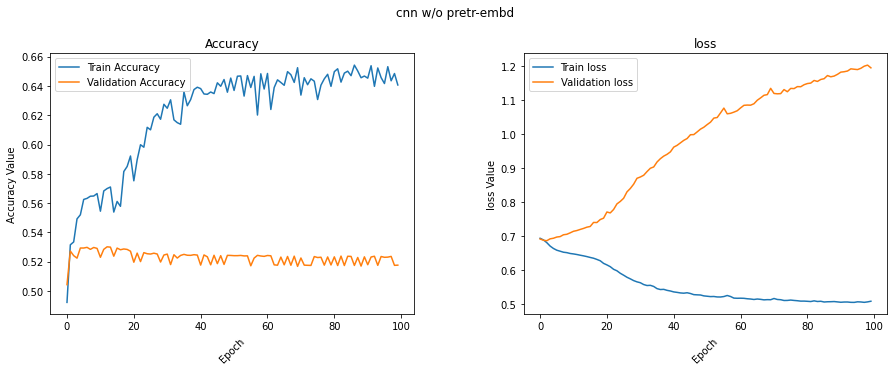

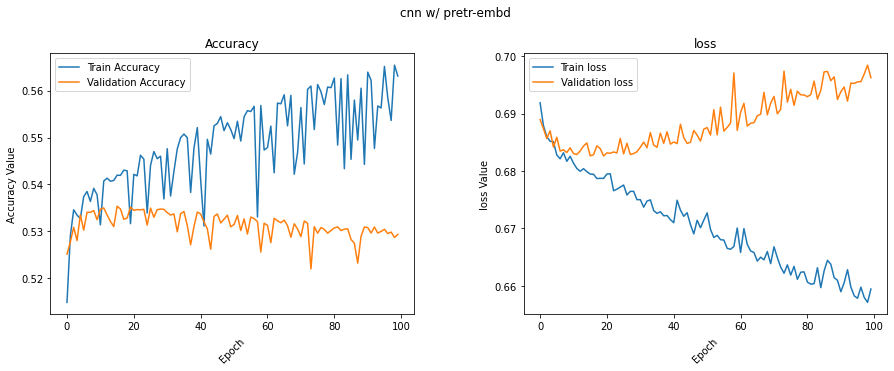

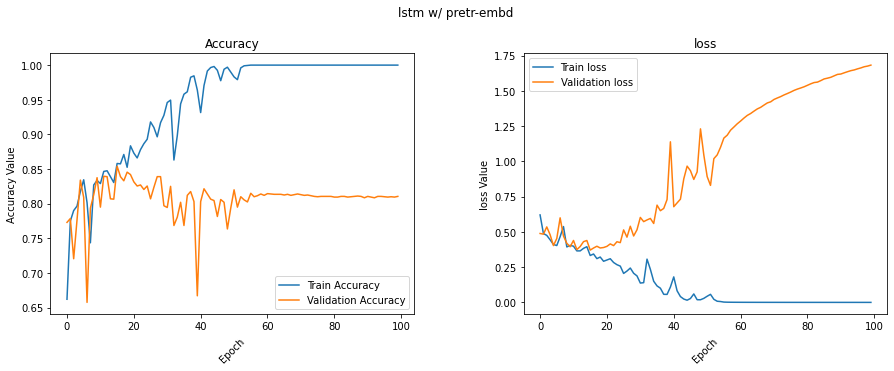

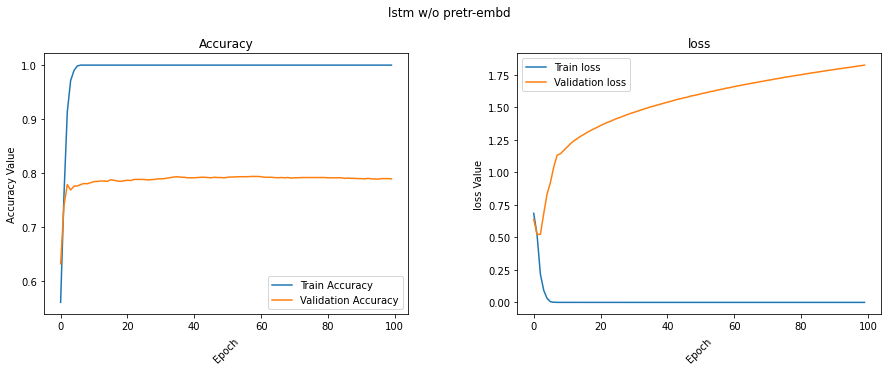

In [40]:
titles = ['cnn w/o pretr-embd','cnn w/ pretr-embd','lstm w/ pretr-embd','lstm w/o pretr-embd']
for i in range(4):      f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5)    
  t = f.suptitle(titles[i], fontsize=1    
  f.subplots_adjust(top=0.85, wspace=0.    

  epochs = list(range(len(hists[i]['acc'])      )
  ax1.plot(epochs, hists[i]['acc'], label='Train Accu    cy')
  ax1.plot(epochs, hists[i]['val_acc'], label='Validation Acc    acy')
  # ax1.set_xticks    pochs)
  ax1.set_ylabel('Accurac    Value')
  ax1.set_xlabel('Epoch',rota    on='45')
  ax1.set_title(    ccuracy')
  l1 = ax1.legend(    c='best')

  ax2.plot(epochs, hists[i]['loss'], label    Train loss')
  ax2.plot(epochs, hists[i]['val_loss'], label='Va    dation loss')
  # ax2.se    xticks(epochs)
  ax2.set_yla    l('loss Value')
  ax2.set_xlabel('Epo    ',rotation='45')
  ax    set_title('loss')
  l2 = ax    legend(loc='best')
  f.show()